In [66]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptune_tokene = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptune_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import neptune
import tensorflow as tf
import random

import io
import cirq
import numpy as np
import statistics as st
from matplotlib import pyplot as plt
from collections import defaultdict
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.circuits import get_discriminator
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.states.butterfly_circuits import ButterflyCircuitBuilder
from qsgenerator.quwgans.real_expectations_provider import PrecomputedExpectationsProvider, \
    Interpolation1DExpectationsProvider, WassersteinGanExpectationProvider, ExpectationProviderType
from qsgenerator.states.simple_rotation_generators import get_fixed_random_rotation_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [99]:
def get_expectation_provider(real, 
                             real_symbols, 
                             known_g_values, 
                             real_values_provider,
                             expectation_provider_type,
                             gen_input_dim=None,
                             hidden_dim=None,
                             penalty_factor=None,
                             gan_epochs=None,
                             batch_size=None,
                             n_crit=None):
    precomputed_expectation_provider = PrecomputedExpectationsProvider(real,
                                                                       real_symbols,
                                                                       known_g_values,
                                                                       real_values_provider,
                                                                       get_discriminator(real))
    if expectation_provider_type == ExpectationProviderType.ONLY_KNOWN:
        return precomputed_expectation_provider
    elif expectation_provider_type == ExpectationProviderType.INTERPOLATION1D:
        return Interpolation1DExpectationsProvider(precomputed_expectation_provider)
    elif expectation_provider_type == ExpectationProviderType.WGAN:
        return WassersteinGanExpectationProvider(precomputed_expectations_provider=precomputed_expectation_provider, 
                                                 gen_input_dim=gen_input_dim, 
                                                 hidden_dim=hidden_dim, 
                                                 penalty_factor=penalty_factor, 
                                                 epochs=gan_epochs, 
                                                 batch_size=batch_size, 
                                                 n_crit=n_crit,
                                                 use_neptune=use_neptune)

In [100]:
def start_neptune_experiment(use_neptune,
                             trainer, 
                             gen,
                             neptune_params,
                             gan_params,
                             description=None):
    if use_neptune:
        neptune.init(project_qualified_name='wiktor.jurasz/thesis-em-exps', api_token=neptune_token)
        if expectation_provider_type == ExpectationProviderType.WGAN:
            neptune_params = {**neptun_params, **gan_params}
        neptune.create_experiment(name=None, description=description, params=neptune_params)
        neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")
        neptune.log_artifact(io.StringIO(str(([(el[0].numpy(), el[1], list(el[2].numpy())) for el in trainer.gen_weights]))), 'init_gen_weights.txt')

In [101]:
def compute_known_states_stats(tra, g_list):
       return compute_states_stats(
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        g_list,
        g_list
    ) 

def compute_generated_states_stats(tra, g_list):
    return compute_states_stats(
        lambda g: tra.gen_evaluator.get_state_from_params()[1],
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        ["GENERATED"],
        g_list
    )

def compute_states_stats(state_prov1, state_prov2, g_list1, g_list2):
    stats = {
        'min_fidelity': 1,
        'min_fidelity_tuple': (None, None),
        'max_fidelity': 0,
        'max_fidelity_tuple': (None, None),
        'average_fidelity': None,
        'std_fidelity': None
    }
    fids = []
    for g1 in g_list1:
        for g2 in g_list2:
            if g1 != g2:
                state1 = state_prov1(g1)
                state2 = state_prov2(g2)
                fid = cirq.fidelity(state1, state2)
                fids.append(fid)
                if fid < stats['min_fidelity']:
                    stats['min_fidelity'] = fid
                    stats['min_fidelity_tuple'] = (g1, g2)
                if fid > stats['max_fidelity']:
                    stats['max_fidelity'] = fid
                    stats['max_fidelity_tuple'] = (g1, g2)
                
    stats['average_fidelity'] = st.mean(fids)
    stats['std_fidelity'] = st.stdev(fids)
    return stats

In [102]:
def run_for_g_values(g_values,
                     real,
                     real_symbols,
                     gen,
                     gs,
                     real_values_provider,
                     rank,
                     epochs,
                     gen_iteration, 
                     snapshot_interval_epochs,
                     description,
                     use_neptune,
                     neptune_params,
                     gan_params):   
    trainers = {}
    training_results = {}
    for g in g_values:
        trainers[g] = Trainer(real, 
                              real_symbols, 
                              gen, 
                              gs, 
                              [g], 
                              real_values_provider, 
                              real_expectations_provider,
                              rank=rank, 
                              use_neptune=use_neptune)

        opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

        start_neptune_experiment(use_neptune=use_neptune,
                                 trainer=trainers[g], 
                                 gen=gen,
                                 neptune_params=neptune_params,
                                 gan_params=gan_params,
                                 description=description)

        json_result =  trainers[g].train(opt=opt, 
                                         epochs=epochs, 
                                         gen_iteration=gen_iteration, 
                                         snapshot_interval_epochs=snapshot_interval_epochs, 
                                         plot=True)
        training_results[g] = json_result
    
        if use_neptune:
            neptune.stop()
    return trainers, training_results

In [103]:
use_neptune = True
generator_layers = 3
data_bus_size = 6
rank = 1
real_circuit_type = 'butterfly'
generic_generator = False
zxz = False
all_gates_parametrized = False
expectation_provider_type = ExpectationProviderType.WGAN
known_g_values = list(range(32))
g_values = [2]

# only relevant is using WGAN provider
gen_input_dim = 16
hidden_dim = [32, 64]
penalty_factor = 10
gan_epochs = 5000
batch_size = 16
n_crit = 2
        
gen_iteration = 2
snapshot_interval_epochs = 200
epochs = 801

description = None

In [104]:
neptune_params = {
            'generator_layers': generator_layers,
            'size':  data_bus_size,
            'rank': rank,
            'real_circuit_type': real_circuit_type,
            'generic_generator': generic_generator,
            'zxz': zxz,
            'all_gates_parametrized': all_gates_parametrized,
            'g_values': g_values,
            'expectation_provider_type': expectation_provider_type,
            'known_g_values': known_g_values,
            'gen_iteration': gen_iteration,
            'epochs': epochs
        }

gan_params = {
                'gen_input_dim': gen_input_dim,
                'hidden_dim': hidden_dim,
                'penalty_factor': penalty_factor,
                'gan_epochs': gan_epochs,
                'batch_size': batch_size,
                'n_crit': n_crit
            }

In [105]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)
if real_circuit_type == 'butterfly':
    real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
    real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
    real_values_provider = get_g_parameters_provider()

if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
    gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)
    
real_expectations_provider = get_expectation_provider(real, 
                                                      real_symbols, 
                                                      known_g_values, 
                                                      real_values_provider,
                                                      expectation_provider_type,
                                                      gen_input_dim=gen_input_dim,
                                                      hidden_dim=hidden_dim,
                                                      penalty_factor=penalty_factor,
                                                      gan_epochs=gan_epochs,
                                                      batch_size=batch_size,
                                                      n_crit=n_crit)

<Figure size 432x288 with 0 Axes>

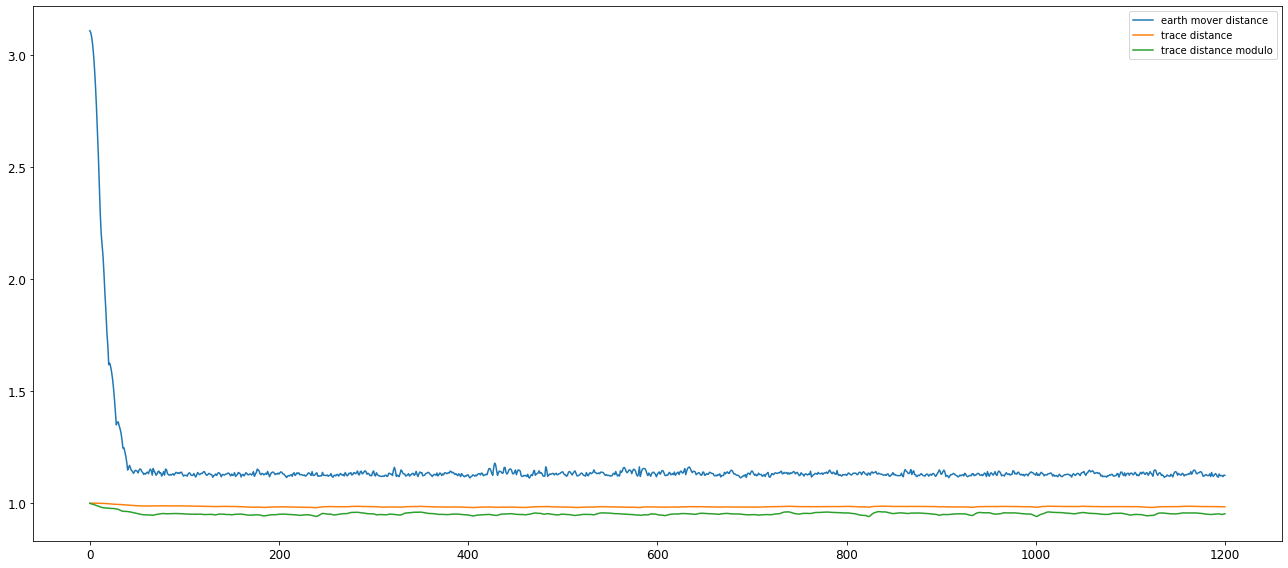

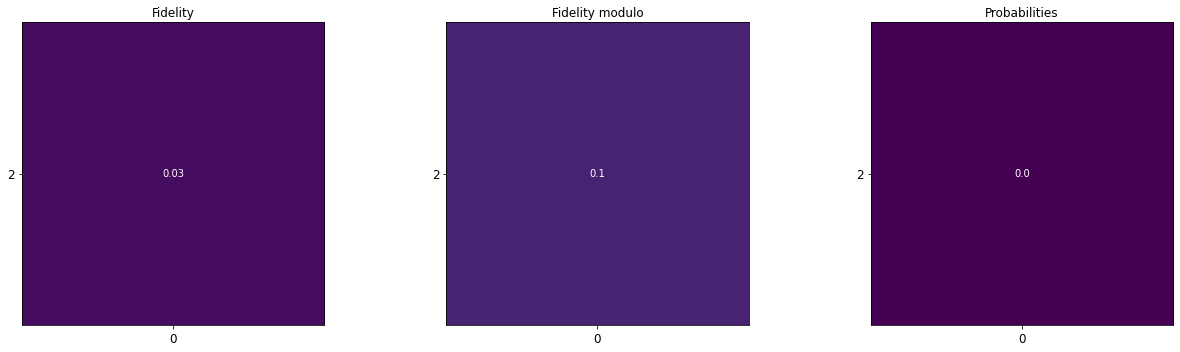

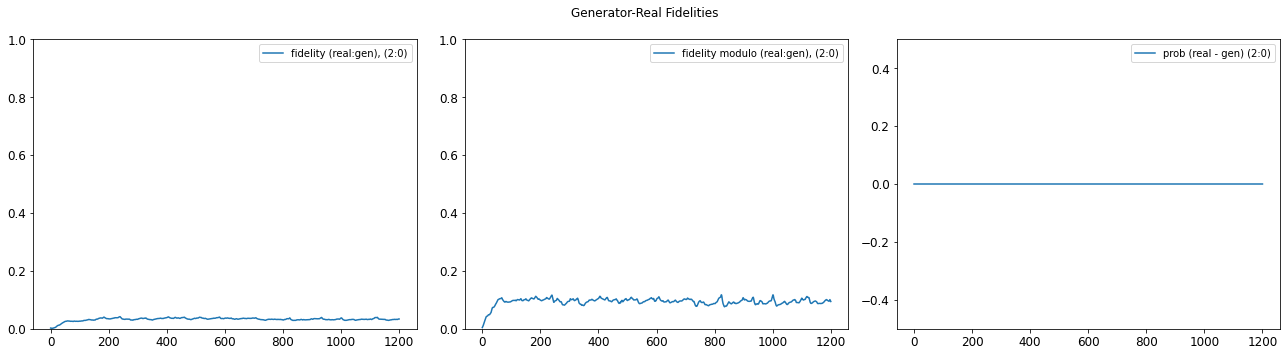

----------------------------------------------------
Epoch 1200:  EM distance = 1.1232881438418791, trace distance = 0.9829214894215557, abs trace distance = 0.9517191434064518
h=X((0, 0))*Y((0, 5)), w=0.9999999722154093, e=0.2837083938890478
h=X((0, 2))*Z((0, 3)), w=0.9999999738353755, e=0.6195279955863953
h=Z((0, 1))*Y((0, 4)), w=0.9999999766925032, e=0.22005178358773136
-------------------------------------
----------- TRAINING DONE -----------


In [106]:
trainers, training_results = run_for_g_values(g_values,
                     real,
                     real_symbols,
                     gen,
                     gs,
                     real_values_provider,
                     rank,
                     epochs,
                     gen_iteration, 
                     snapshot_interval_epochs,
                     description,
                     use_neptune,
                     neptune_params,
                     gan_params)

In [107]:
trainer = trainers[2]
re_exps = trainer.real_expectations_provider.get_expectations_for_parameters([1])[1]
{s: e for s, e in re_exps.items() if abs(e) > 0.1}

{Z((0, 0))*Z((0, 2)): -0.58371574,
 Y((0, 0))*Z((0, 2)): -0.59329176,
 Y((0, 0))*Y((0, 2)): -0.90434396,
 Y((0, 0))*X((0, 2)): 0.7195716,
 X((0, 0))*Z((0, 2)): 0.28209972,
 X((0, 0))*Y((0, 2)): -0.20214343,
 X((0, 0))*X((0, 2)): -0.9349686,
 Z((0, 0))*Z((0, 4)): 0.38018024,
 Z((0, 0))*Y((0, 4)): -0.5838524,
 Z((0, 0))*X((0, 4)): -0.97757095,
 Y((0, 0))*Z((0, 4)): -0.37516356,
 Y((0, 0))*Y((0, 4)): 0.43884552,
 Y((0, 0))*X((0, 4)): -0.72893703,
 X((0, 0))*Z((0, 4)): -0.4330455,
 X((0, 0))*Y((0, 4)): -0.10846555,
 X((0, 0))*X((0, 4)): -0.16063195,
 Z((0, 0))*Z((0, 1)): -0.19416362,
 Z((0, 0))*Y((0, 1)): -0.17457747,
 Z((0, 0))*X((0, 1)): -0.19685197,
 Y((0, 0))*Z((0, 1)): -0.48191983,
 Y((0, 0))*Y((0, 1)): -0.67872965,
 Y((0, 0))*X((0, 1)): -0.25021625,
 X((0, 0))*Z((0, 1)): 0.21814501,
 X((0, 0))*Y((0, 1)): -0.6018639,
 X((0, 0))*X((0, 1)): -0.41161883,
 Z((0, 0))*Y((0, 5)): -0.5950844,
 Y((0, 0))*Z((0, 5)): -0.83873093,
 Y((0, 0))*Y((0, 5)): -0.5693088,
 X((0, 0))*Z((0, 5)): 0.42210102

In [108]:
trainer.real_expectations_provider.precomputed_expectations_provider.eps = 0.1
trainer.real_expectations_provider.precomputed_expectations_provider.get_expectations_for_parameters([2], filter_small_expectations=True)

{2: {Z((0, 0))*Z((0, 2)): 0.8172459,
  Y((0, 0))*Z((0, 2)): -0.41398478,
  Z((0, 0))*Y((0, 4)): -0.2601716,
  Z((0, 0))*X((0, 4)): 0.10546628,
  Y((0, 0))*Y((0, 4)): 0.12056101,
  Z((0, 0))*Z((0, 1)): -0.18103306,
  Z((0, 0))*Y((0, 1)): -0.3012513,
  Z((0, 0))*X((0, 1)): 0.16096301,
  X((0, 0))*Z((0, 1)): -0.108466305,
  X((0, 0))*Y((0, 1)): 0.14183348,
  Z((0, 0))*Y((0, 5)): -0.6850423,
  Y((0, 0))*Y((0, 5)): 0.34701288,
  Z((0, 0))*Z((0, 3)): -0.15791652,
  Z((0, 0))*Y((0, 3)): -0.14377077,
  X((0, 0))*Z((0, 3)): -0.14637472,
  X((0, 0))*X((0, 3)): -0.2066124,
  Z((0, 2))*Y((0, 4)): -0.28974694,
  Z((0, 2))*X((0, 4)): 0.117714696,
  Z((0, 1))*Z((0, 2)): -0.18901733,
  Y((0, 1))*Z((0, 2)): -0.2556628,
  X((0, 1))*Z((0, 2)): 0.12774971,
  Z((0, 2))*Y((0, 5)): -0.8382223,
  Y((0, 2))*Z((0, 5)): -0.14205834,
  X((0, 2))*X((0, 5)): 0.16949141,
  Z((0, 2))*Z((0, 3)): -0.17322414,
  Z((0, 2))*Y((0, 3)): -0.1446191,
  Z((0, 1))*Z((0, 4)): 0.355675,
  X((0, 1))*Y((0, 4)): -0.34451666,
  Y((0,